In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

In [14]:
fit = pd.read_csv('/data/log/lioncrashfric2.5b8logoften/rep00/fitnesslog.txt', delimiter="\t")
fit.head()

,gen,ind,rep,fake,fitness
0,0,0,0,1.221160,13998.500
1,0,1,0,0.883807,933.340
2,0,2,0,1.065790,212.617
3,0,3,0,1.279580,2057.950
4,0,4,0,0.686850,944.421


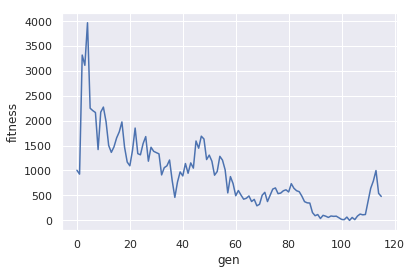

In [15]:
sns.lineplot(y='fitness', x='gen', data=fit, ci=None, estimator='median')
#sns.lineplot(y='fitness', x='gen', data=fit, ci=None, estimator='max')
